In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# displacement charges
dq_trajs = list(np.load(f"{DATA_DIR}/raw_feat/displacement_q_0-178.npy"))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_179-end.npy", allow_pickle=True))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_anton2.npy"))
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8]  # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[
    0
]  # 0.1 ns lag time

# remove trajectory 180 (missing full data)
cv_trajs = [*cv_trajs[:180], *cv_trajs[181:]]
sb_trajs = [*sb_trajs[:180], *sb_trajs[181:]]
sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)
qp_du = [*qp_du[:180], *qp_du[181:]]
weights = [*weights[:180], *weights[181:]]

In [5]:
print(
    cv_arr.shape,
    sb_arr.shape,
    np.concatenate(qp_du).shape,
    np.concatenate(dq_trajs).shape,
)

(4050115, 2) (4050115, 60) (4050115,) (4050115,)


In [6]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [7]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# Compute committor time correlation function

In [93]:
def autocorrelation(trajs, maxlag, weights):
    n_dim = trajs[0].shape[-1]
    ans = np.zeros((maxlag, n_dim))
    for t in range(1, maxlag):
        num = 0
        denom = 0
        for traj, w in zip(trajs, weights):
            num += np.mean(w[:-t, None] * traj[:-t] * traj[t:], axis=0)
            denom += np.mean(w[:-t, None] * (traj[:-t] ** 2), axis=0)
        ans[t] = num / denom
    ans[0, :] = 1
    return ans

In [8]:
from scipy import signal

In [86]:
def autocorrelation_fft(trajs, maxlag, weights):
    ans = np.zeros(maxlag)
    for traj, w in zip(trajs, weights):
        assert len(traj) == len(w)
        start = len(traj)
        num = signal.correlate(w * traj, traj)[start - maxlag : start][::-1]
        denom = num[0]
        ans += num / denom
    return ans

In [87]:
dq_acf = autocorrelation_fft(dq_trajs, 5000, weights)

Text(0, 0.5, '$C_{zz}(\\tau)$')

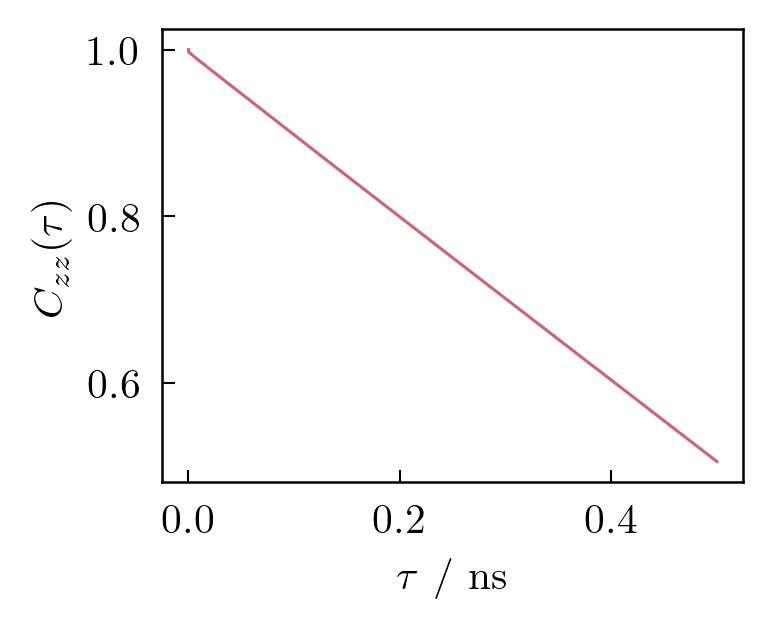

In [88]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
plt.plot(np.arange(5000) * 0.0001, dq_acf / len(dq_trajs))
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")

In [89]:
qp_acf = autocorrelation_fft(qp_du, 5000, weights)

Text(0, 0.5, '$C_{zz}(\\tau)$')

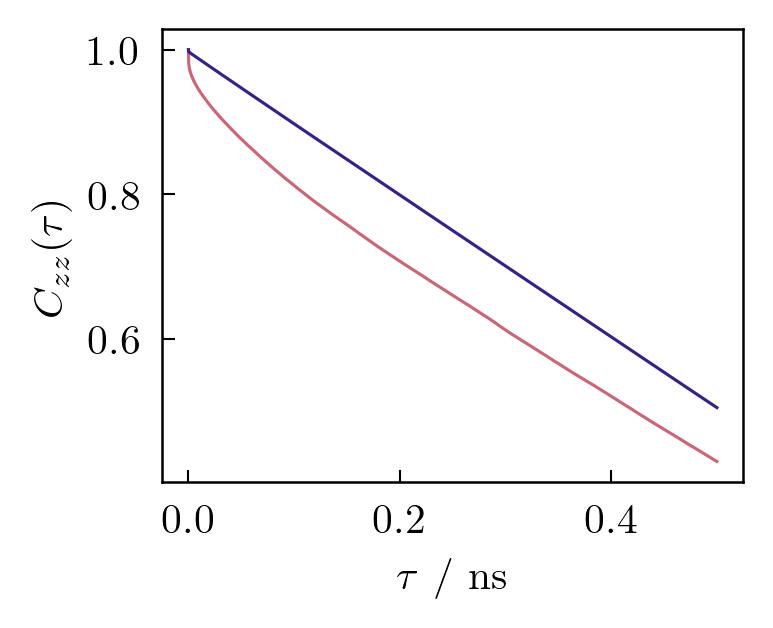

In [90]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
plt.plot(np.arange(5000) * 0.0001, qp_acf / len(dq_trajs))
plt.plot(np.arange(5000) * 0.0001, dq_acf / len(dq_trajs))
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")

In [91]:
trajs = [
    np.concatenate((q[:, None], dq[:, None], cv), axis=-1) for (q, dq, cv) in zip(qp_du, dq_trajs, cv_trajs)
]

In [ ]:
maxlag = 5000
acf = autocorrelation(trajs, maxlag, weights)

In [ ]:
np.save(f"{DATA_DIR}/acf_qp_dq_ds.npy", acf)

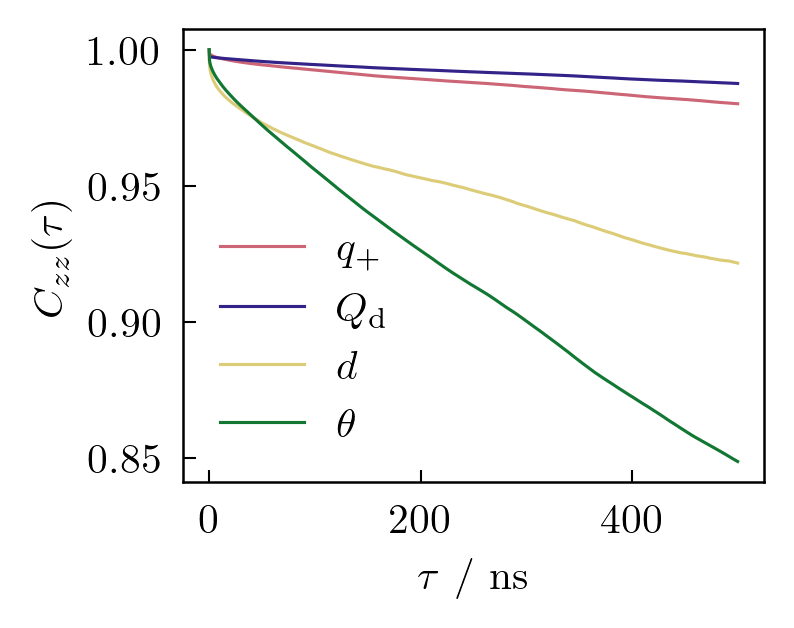

In [96]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))

labels = ["$q_+$", "$Q_{\\mathrm{d}}$", "$d$", "$\\theta$"]
for i in range(4):
    plt.plot(np.arange(maxlag) * 0.1, acf[:, i], label=labels[i])
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

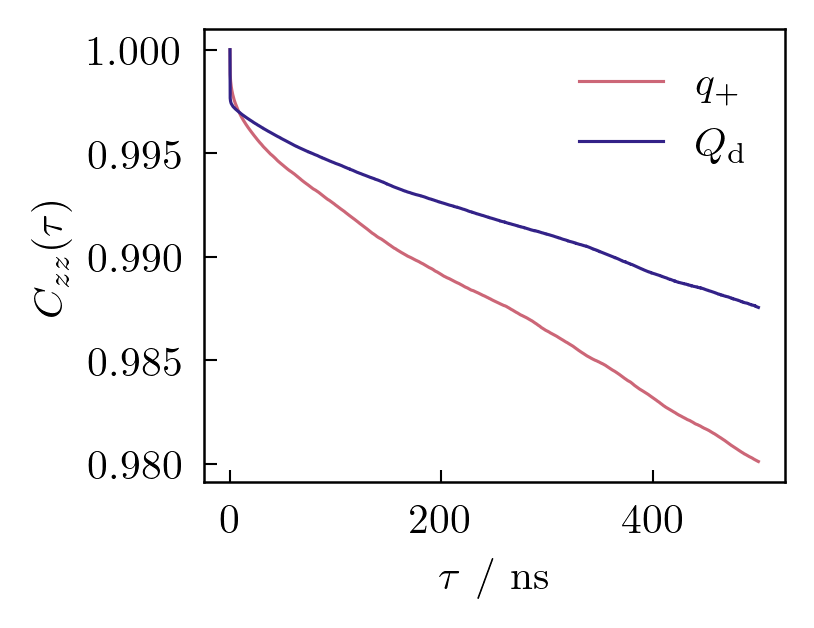

In [97]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))

labels = ["$q_+$", "$Q_{\\mathrm{d}}$", "$d$", "$\\theta$"]
for i in range(2):
    plt.plot(np.arange(maxlag) * 0.1, acf[:, i], label=labels[i])
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

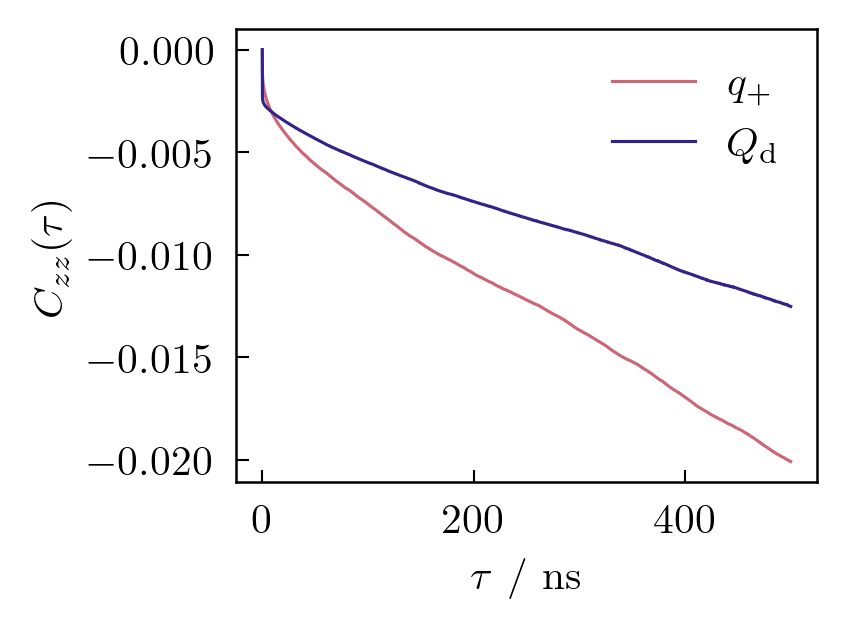

In [98]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))

labels = ["$q_+$", "$Q_{\\mathrm{d}}$", "$d$", "$\\theta$"]
for i in range(2):
    plt.plot(np.arange(maxlag) * 0.1, np.log(acf[:, i]), label=labels[i])
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()
# plt.semilogy()

# Fit exponential decay

In [99]:
def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K


def model_func(params, t, y):
    return params[0] * np.exp(params[1] * t) - y

In [100]:
x0 = (1.0, -1.0)
t = np.arange(maxlag) * 0.1
res_lsq = scipy.optimize.least_squares(model_func, x0, args=(t[1:], acf[1:, 1]))

In [101]:
def exp_fun(params, t):
    return params[0] * np.exp(params[1] * t)

Text(0.6, 0.6, '$Ae^{-t/\\tau}$\n$A$ = -0.000\n$\\tau$ = 3.26 $\\mu$s')

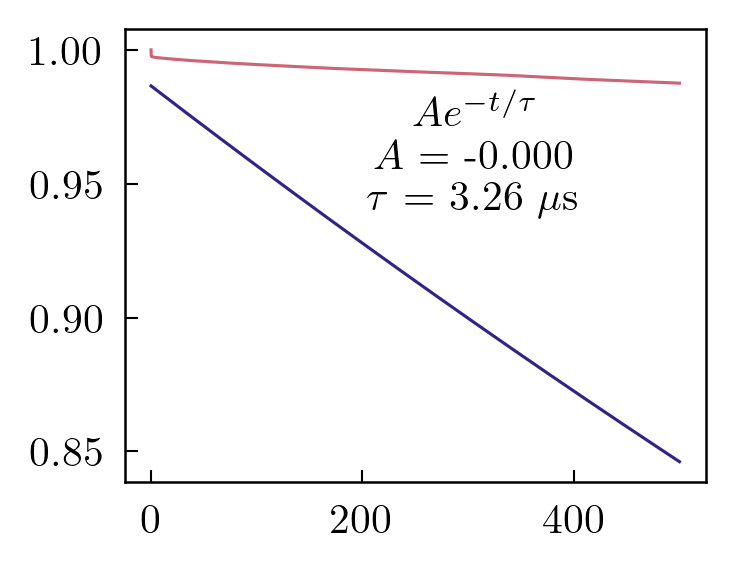

In [107]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
plt.plot(t, acf[:, 1])
plt.plot(t, exp_fun(res_lsq.x, t))
plt.text(
    0.6,
    0.6,
    f"$Ae^{{-t/\\tau}}$\n$A$ = {res_lsq.x[1]:.3f}\n$\\tau$ = {- 1e-3 / res_lsq.x[1]:.2f} $\\mu$s",
    transform=ax.transAxes,
    ha="center",
)

In [108]:
x0 = (1.0, -1)
t = np.arange(maxlag) * 0.1
res_all = []
for i in range(4):
    res_lsq = scipy.optimize.least_squares(model_func, x0, args=(t[1:], acf[1:, i]))
    res_all.append(res_lsq)

$q_+$ $A$ = 0.996$\tau$ = 30.88 $\mu$s
$Q_{\mathrm{d}}$ $A$ = 0.996$\tau$ = 54.83 $\mu$s
$d$ $A$ = 0.979$\tau$ = 7.87 $\mu$s
$\theta$ $A$ = 0.987$\tau$ = 3.26 $\mu$s


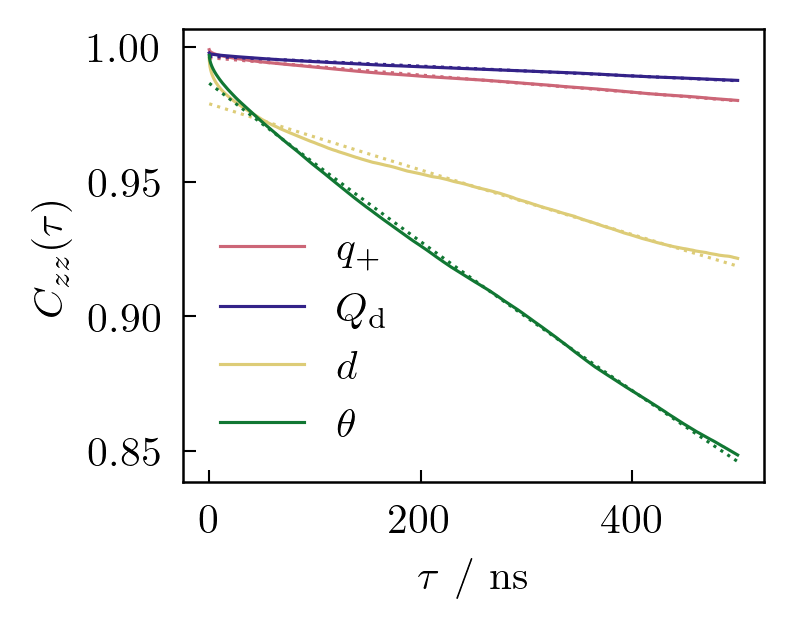

In [109]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
for i in range(4):
    res_lsq = res_all[i]
    plt.plot(t[1:], acf[1:, i], label=labels[i])
    plt.plot(t[1:], exp_fun(res_lsq.x, t[1:]), ':', color=f"C{i}")
    print(
        f"{labels[i]:} $A$ = {res_lsq.x[0]:.3f}$\\tau$ = {- 1e-3 / res_lsq.x[1]:.2f} $\\mu$s",
    )
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

$q_+$ $A$ = 0.996$\tau$ = 3.09e+04
$Q_{\mathrm{d}}$ $A$ = 0.996$\tau$ = 5.48e+04


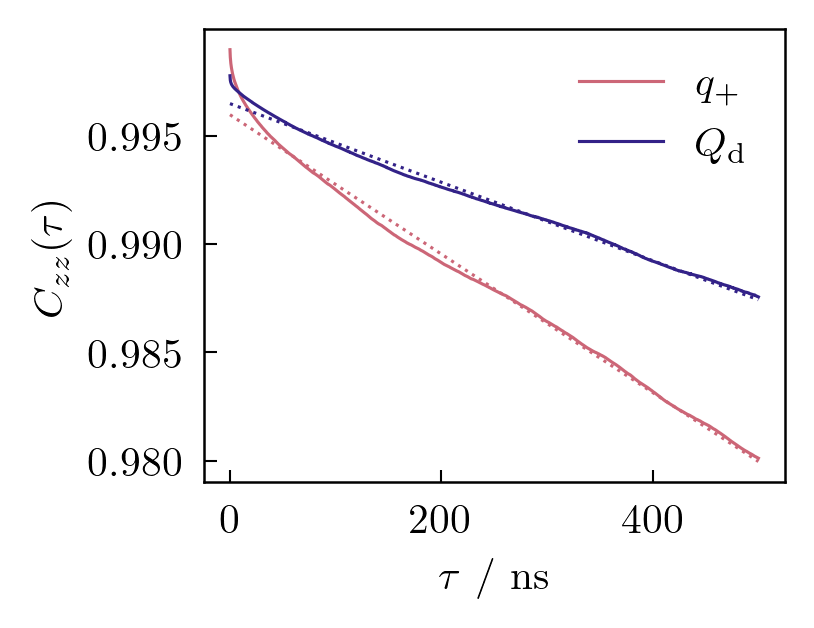

In [110]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
for i in range(2):
    res_lsq = res_all[i]
    plt.plot(t[1:], acf[1:, i], label=labels[i])
    plt.plot(t[1:], exp_fun(res_lsq.x, t[1:]), ':', color=f"C{i}")
    print(
        f"{labels[i]:} $A$ = {res_lsq.x[0]:.3f}$\\tau$ = {- 1 / res_lsq.x[1]:.2e}",
    )
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

## Fit biexponential

In [111]:
def biexp_model(params, t, y):
    return params[0] * np.exp(params[1] * t) + params[2] * np.exp(params[3] * t) - y

def biexp_fun(params, t):
    return params[0] * np.exp(params[1] * t) + params[2] * np.exp(params[3] * t)

In [66]:
x0 = (1.0, -1.0, 1.0, -1.0)
t = np.arange(5000) * 0.0001
res_biexp = []
for i in (qp_acf, dq_acf):
    res_biexp.append(scipy.optimize.least_squares(biexp_model, x0, args=(t[1:], i[1:] / len(dq_trajs))))

$q_+$ A1 = 0.946, tau1 = 0.69, A2 = -0.000, tau2 = -0.07
$Q_{\mathrm{d}}$ A1 = 1.498, tau1 = 2.22, A2 = -0.502, tau2 = -1.56


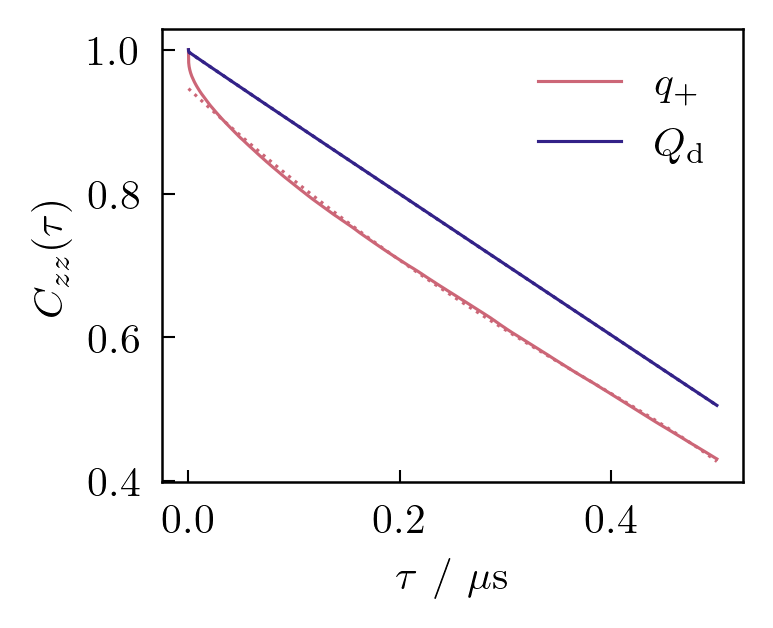

In [67]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
labels = ["$q_+$", "$Q_{\\mathrm{d}}$", "$d$", "$\\theta$"]
for i, acf in enumerate((qp_acf, dq_acf)):
    res_lsq = res_biexp[i]
    plt.plot(t, acf / len(dq_trajs), label=labels[i])
    plt.plot(t, biexp_fun(res_lsq.x, t), ':', color=f"C{i}")
    print(
        f"{labels[i]:} A1 = {res_lsq.x[0]:.3f}, tau1 = {- 1 / res_lsq.x[1]:.2f}, A2 = {res_lsq.x[2]:.3f}, tau2 = {- 1 / res_lsq.x[3]:.2f}",
    )
plt.xlabel(r"$\tau$ / $\mu$s")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

In [132]:
x0 = (1.0, -1.0, 1.0, -1.0)
t = np.arange(maxlag) * 0.1
res_biexp = []
for i in range(4):
    res_biexp.append(scipy.optimize.least_squares(biexp_model, x0, args=(t[1:], acf[1:, i])))

In [133]:
res_biexp[0].optimality

5.529501188525354e-07

$q_+$ A1 = 0.003, tau1 = 0.03, A2 = 0.995, tau2 = 32.66
$Q_{\mathrm{d}}$ A1 = 0.996, tau1 = 58.65, A2 = 0.001, tau2 = 0.04


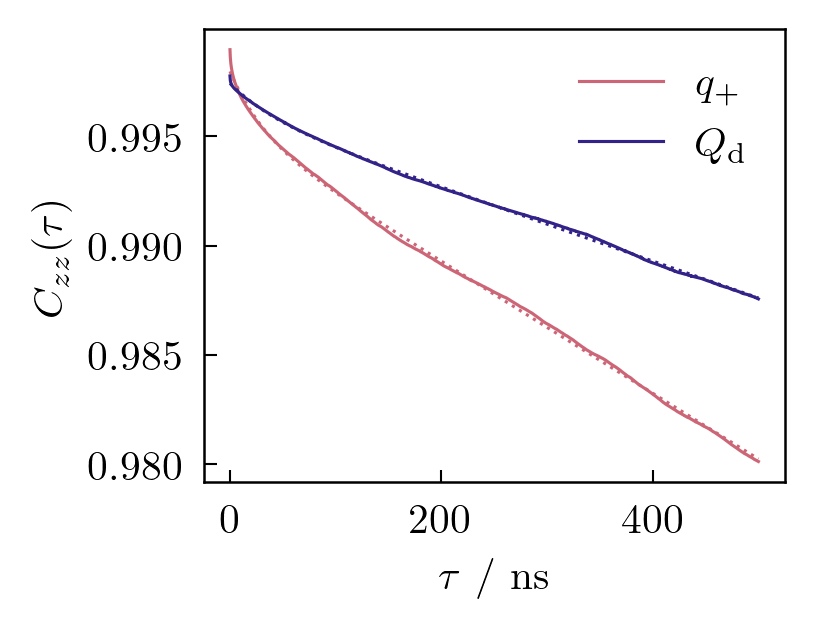

In [134]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
for i in range(2):
    res_lsq = res_biexp[i]
    plt.plot(t[1:], acf[1:, i], label=labels[i])
    plt.plot(t[1:], biexp_fun(res_lsq.x, t[1:]), ':', color=f"C{i}")
    print(
        f"{labels[i]:} A1 = {res_lsq.x[0]:.3f}, tau1 = {- 1e-3 / res_lsq.x[1]:.2f}, A2 = {res_lsq.x[2]:.3f}, tau2 = {- 1e-3 / res_lsq.x[3]:.2f}",
    )
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

$q_+$ A1 = 0.003, tau1 = 3.17e+01, A2 = 0.995, tau2 = 3.27e+04
$Q_{\mathrm{d}}$ A1 = 0.996, tau1 = 5.87e+04, A2 = 0.001, tau2 = 4.37e+01
$d$ A1 = 0.016, tau1 = 3.07e+01, A2 = 0.975, tau2 = 8.61e+03
$\theta$ A1 = 0.010, tau1 = 4.79e+01, A2 = 0.983, tau2 = 3.37e+03


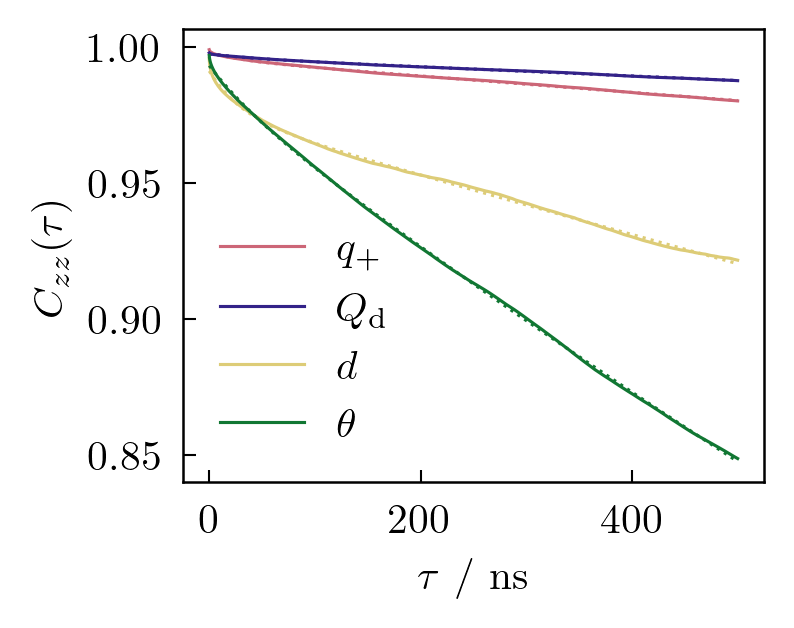

In [117]:
fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
for i in range(4):
    res_lsq = res_biexp[i]
    plt.plot(t[1:], acf[1:, i], label=labels[i])
    plt.plot(t[1:], biexp_fun(res_lsq.x, t[1:]), ':', color=f"C{i}")
    print(
        f"{labels[i]:} A1 = {res_lsq.x[0]:.3f}, tau1 = {- 1 / res_lsq.x[1]:.2e}, A2 = {res_lsq.x[2]:.3f}, tau2 = {- 1 / res_lsq.x[3]:.2e}",
    )
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$C_{zz}(\tau)$")
plt.legend()

(0.985, 1.0)

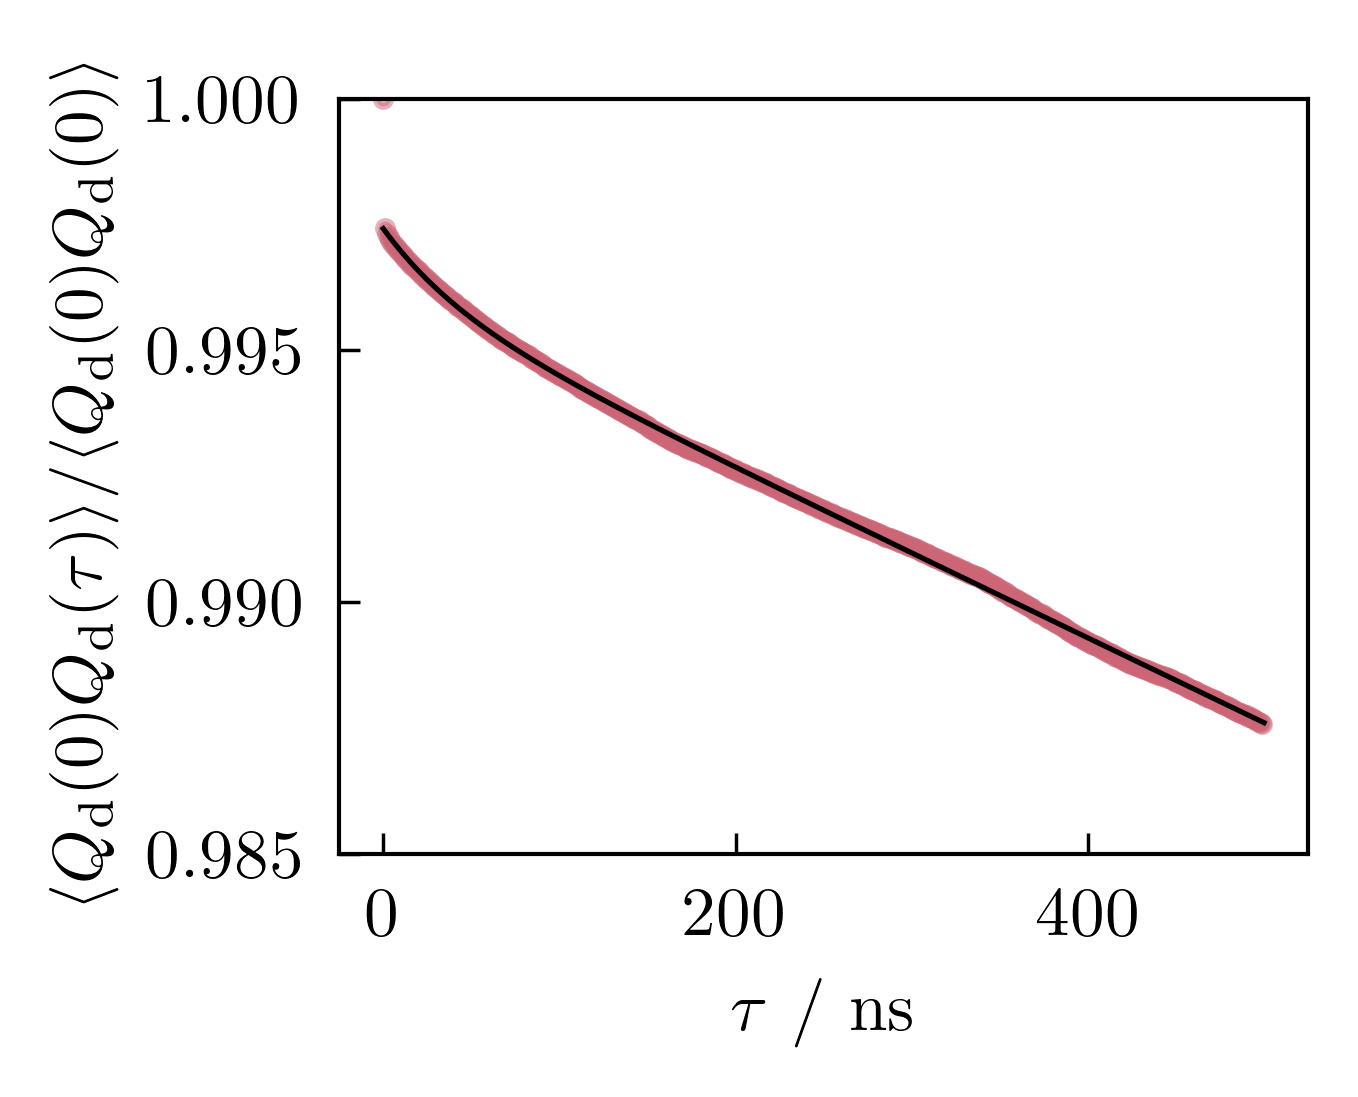

In [128]:
fig = plt.figure(dpi=500, figsize=(2.5, 2))
ax = plt.gca()
i = 1
res_lsq = res_biexp[i]
plt.plot(t[::10], acf[::10, i], 'o', mfc=None, alpha=0.5, label=labels[i])
plt.plot(t, biexp_fun(res_lsq.x, t), color=f"black")
# plt.text(0.5, 0.1,
#     f"A1 = {res_lsq.x[0]:.3f}, tau1 = {- 1e-3 / res_lsq.x[1]:.2f}, A2 = {res_lsq.x[2]:.3f}, tau2 = {- 1e-3 / res_lsq.x[3]:.2f}",
#     transform=ax.transAxes,
#     ha='center'
# )
plt.xlabel(r"$\tau$ / ns")
plt.ylabel(r"$\langle Q_{\mathrm{d}}(0) Q_{\mathrm{d}}(\tau) \rangle / \langle Q_{\mathrm{d}}(0) Q_{\mathrm{d}}(0) \rangle$")
plt.xlim([
plt.ylim([0.985, 1.0])